<div style="background: linear-gradient(90deg, #0f2027 0%, #2c5364 100%); color:#fff; padding:32px 30px 28px 30px; border-radius:20px; box-shadow: 0 8px 32px 0 rgba(44,83,100,0.35); font-size:20px; font-family:'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-bottom: 28px;">
  <h1 style="color:#7cf9ff; margin-top:0; font-size:2.5em; letter-spacing:1px; text-shadow:0 2px 10px #111;">📚 Table of Contents</h1>
  <ul style="list-style:none; padding-left:0; margin-top:18px;">
    <li style="margin-bottom:10px;"><a href="#setup-data-loading" style="color:#ffe066; font-weight:bold; font-size:1.1em;">1. Setup & Data Loading</a></li>
    <li style="margin-bottom:10px;"><a href="#data-cleaning-feature-engineering" style="color:#ffe066; font-weight:bold; font-size:1.1em;">2. Data Cleaning & Feature Engineering</a></li>
    <li style="margin-bottom:10px;"><a href="#summary-statistics-key-metrics" style="color:#ffe066; font-weight:bold; font-size:1.1em;">3. Summary Statistics & Key Metrics</a></li>
    <li style="margin-bottom:10px;"><a href="#anomaly-detection" style="color:#ffe066; font-weight:bold; font-size:1.1em;">4. Anomaly Detection</a></li>
    <li style="margin-bottom:10px;"><a href="#interactive-visualizations" style="color:#ffe066; font-weight:bold; font-size:1.1em;">5. Interactive Visualizations</a></li>
    <li style="margin-bottom:10px;"><a href="#additional-professional-visuals" style="color:#ffe066; font-weight:bold; font-size:1.1em;">6. Additional Professional Visuals</a></li>
    <li style="margin-bottom:10px;"><a href="#risk-metrics-visualization" style="color:#ffe066; font-weight:bold; font-size:1.1em;">7. Risk Metrics Visualization</a></li>
  <div style="margin-top:22px; font-size:1em; color:#b3e0ff;">
    <b>Tip:</b> Click any section to jump directly to it. <br>
    For best navigation, use matching anchor tags or markdown headers in each section.
  </div>
</div>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stock-data/netflix.csv
/kaggle/input/stock-data/nvidia.csv
/kaggle/input/stock-data/tesla.csv
/kaggle/input/stock-data/apple.csv
/kaggle/input/google-stocks-historical-data/Google_stock_data.csv


<div style="background-color:#232038; color:#f3f3f3; padding:22px; border-radius:14px; font-size:18px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;">
  <h2 style="color:#7cf9ff; margin-top:0;">🚀 Step 1: Setup & Data Loading</h2>
  <p></p>
</div>


In [2]:
# Install Prophet (the new name for fbprophet)
!pip install --quiet prophet


In [3]:
# Step 1: Setup & Data Loading

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from prophet import Prophet

# Load the data from Kaggle input directory
df = pd.read_csv("/kaggle/input/stock-data/apple.csv")
# Preview data
df.head()


,Date,Close,High,Low,Open,Volume
0,1980-12-12,0.098597,0.099025,0.098597,0.098597,469033600
1,1980-12-15,0.093453,0.093881,0.093453,0.093881,175884800
2,1980-12-16,0.086594,0.087022,0.086594,0.087022,105728000
3,1980-12-17,0.088737,0.089165,0.088737,0.088737,86441600
4,1980-12-18,0.091310,0.091738,0.091310,0.091310,73449600


In [4]:
print(df.isnull().sum())

Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


<div style="background-color:#232038; color:#f3f3f3; padding:22px; border-radius:14px; font-size:18px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;">
  <h2 style="color:#7cf9ff; margin-top:0;">🧹 Step 2: Data Cleaning & Feature Engineering</h2>
  <p></p>
</div>


In [5]:
# Step 2: Data Cleaning & Feature Engineering

# Drop missing values
df.dropna(inplace=True)

# Ensure correct data types
df[['Close', 'High', 'Low', 'Open']] = df[['Close', 'High', 'Low', 'Open']].astype(float)
df['Volume'] = df['Volume'].astype(int)

# Daily Returns
df['Daily Return'] = df['Close'].pct_change()

# Moving Averages
df['MA20'] = df['Close'].rolling(window=20).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()

# Bollinger Bands
rolling_std = df['Close'].rolling(window=20).std()
df['BB_upper'] = df['MA20'] + (rolling_std * 2)
df['BB_lower'] = df['MA20'] - (rolling_std * 2)

# RSI Calculation
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI14'] = compute_rsi(df['Close'])

# MACD Calculation
exp1 = df['Close'].ewm(span=12, adjust=False).mean()
exp2 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = exp1 - exp2
df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

df.tail()


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


,Date,Close,High,Low,Open,Volume,Daily Return,MA20,MA50,BB_upper,BB_lower,RSI14,MACD,MACD_signal
11227,2025-07-01,207.820007,210.190002,206.139999,206.669998,78788900,0.012916,200.9630,202.976921,206.925115,195.000886,59.360251,0.262378,-0.743963
11228,2025-07-02,212.440002,213.339996,208.139999,208.910004,67941800,0.022231,201.4215,203.367580,209.249147,193.593854,74.185567,1.065211,-0.382128
11229,2025-07-03,213.550003,214.649994,211.809998,212.149994,34955800,0.005225,201.9580,203.649012,211.477292,192.438708,74.801261,1.770619,0.048421
11230,2025-07-07,209.949997,216.229996,208.800003,212.679993,50229000,-0.016858,202.4240,203.761371,212.561950,192.286049,72.666220,2.015931,0.441923
11231,2025-07-08,210.009995,211.429993,208.449997,210.100006,42780600,0.000286,202.7285,203.799628,213.407062,192.049937,70.792964,2.189940,0.791527


<div style="background-color:#232038; color:#f3f3f3; padding:22px; border-radius:14px; font-size:18px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;">
  <h2 style="color:#7cf9ff; margin-top:0;">📊 Step 3: Summary Statistics & Key Metrics</h2>
  <p></p>
</div>


In [6]:
# Ensure 'Date' column is datetime
df['Date'] = pd.to_datetime(df['Date'])

print("Summary Statistics:")
display(df.describe())

print(f"Date Range: {df['Date'].min().date()} to {df['Date'].max().date()}")

max_close = df.loc[df['Close'].idxmax()]
min_close = df.loc[df['Close'].idxmin()]
print(f"Highest Close: {max_close['Close']:.2f} on {max_close['Date'].date()}")
print(f"Lowest Close: {min_close['Close']:.2f} on {min_close['Date'].date()}")

volatility = df['Daily Return'].std()
print(f"Daily Return Volatility: {volatility:.4f}")

sharpe_ratio = df['Daily Return'].mean() / volatility * np.sqrt(252)
print(f"Annualized Sharpe Ratio: {sharpe_ratio:.2f}")

df['Cumulative Return'] = (1 + df['Daily Return']).cumprod()
df['Cumulative Roll Max'] = df['Cumulative Return'].cummax()
df['Drawdown'] = df['Cumulative Return'] / df['Cumulative Roll Max'] - 1
max_drawdown = df['Drawdown'].min()
print(f"Max Drawdown: {max_drawdown:.2%}")


Summary Statistics:


,Date,Close,High,Low,Open,Volume,Daily Return,MA20,MA50,BB_upper,BB_lower,RSI14,MACD,MACD_signal
count,11232,11232.000000,11232.000000,11232.000000,11232.000000,1.123200e+04,11231.000000,11213.000000,11183.000000,11213.000000,11213.000000,11219.000000,11232.000000,11232.000000
mean,2003-03-15 08:08:04.615384704,25.604440,25.863817,25.319221,25.583260,3.125722e+08,0.001074,25.473915,25.271032,27.014198,23.933632,53.304731,0.126246,0.125964
min,1980-12-12 00:00:00,0.037724,0.038153,0.037724,0.038153,0.000000e+00,-0.518692,0.043018,0.044514,0.047249,0.022935,2.898350,-10.616152,-8.325011
25%,1992-01-21 18:00:00,0.244612,0.249967,0.239494,0.244433,1.088385e+08,-0.012585,0.247243,0.252879,0.273068,0.217630,40.474723,-0.005921,-0.005371
50%,2003-03-12 12:00:00,0.460777,0.467169,0.452794,0.459325,2.008968e+08,0.000000,0.467573,0.456376,0.504413,0.419093,53.246487,0.002979,0.003063
75%,2014-05-07 06:00:00,20.077730,20.285163,19.956017,20.110934,3.921155e+08,0.014330,20.033498,19.555078,20.925321,18.906011,66.581502,0.060377,0.058344
max,2025-07-08 00:00:00,258.396667,259.474086,257.010028,257.568678,7.421641e+09,0.332280,249.383421,240.170862,264.635275,239.743681,97.864628,8.913714,8.281466
std,NaN,53.358890,53.888746,52.766259,53.303122,3.341056e+08,0.027759,53.109399,52.732575,56.272868,49.990906,17.515224,1.094853,1.025663


Date Range: 1980-12-12 to 2025-07-08
Highest Close: 258.40 on 2024-12-26
Lowest Close: 0.04 on 1982-07-08
Daily Return Volatility: 0.0278
Annualized Sharpe Ratio: 0.61
Max Drawdown: -81.80%


<div style="background-color:#232038; color:#f3f3f3; padding:22px; border-radius:14px; font-size:18px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;">
  <h2 style="color:#7cf9ff; margin-top:0;">🚨 Step 4: Anomaly Detection</h2>
  <p></p>
</div>


In [7]:
# Step 4: Anomaly Detection

return_threshold = 3 * volatility
anomalies_return = df[abs(df['Daily Return']) > return_threshold]

volume_threshold = df['Volume'].mean() + 3 * df['Volume'].std()
anomalies_volume = df[df['Volume'] > volume_threshold]

print(f"Anomalies in Daily Return (>|3σ|): {len(anomalies_return)} days")
display(anomalies_return[['Date', 'Daily Return', 'Close']])

print(f"Anomalies in Volume (>|3σ|): {len(anomalies_volume)} days")
display(anomalies_volume[['Date', 'Volume', 'Close']])


Anomalies in Daily Return (>|3σ|): 144 days


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


,Date,Daily Return,Close
9,1980-12-26,0.092309,0.121746
76,1981-04-02,0.087632,0.090452
198,1981-09-25,-0.129776,0.048870
256,1981-12-17,0.083327,0.072447
319,1982-03-19,0.090173,0.057015
...,...,...,...
9912,2020-04-06,0.087237,63.612541
9993,2020-07-31,0.104688,103.292046
10568,2022-11-10,0.088975,144.991837
11167,2025-04-03,-0.092456,202.923904


Anomalies in Volume (>|3σ|): 212 days


,Date,Volume,Close
703,1983-09-23,2832345600,0.083164
2054,1989-01-27,2127171200,0.261563
2612,1991-04-15,1700384000,0.443360
2624,1991-05-01,1868372800,0.336526
3183,1993-07-16,2120596800,0.199852
...,...,...,...
7417,2010-05-07,1676018400,7.088582
7593,2011-01-18,1880998000,10.237955
7865,2012-02-15,1506120000,14.957070
7884,2012-03-14,1418844000,17.719349


<div style="background-color:#232038; color:#f3f3f3; padding:22px; border-radius:14px; font-size:18px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;">
  <h2 style="color:#7cf9ff; margin-top:0;">📈 Step 5: Interactive Visualizations</h2>
  <p></p>
</div>


In [8]:
# Step 5: Interactive Visualizations with Plotly

import plotly.io as pio
pio.renderers.default = 'iframe'  # Ensures visuals appear in Kaggle output

# Closing Price with MA and Bollinger Bands
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], mode='lines', name='Close Price'))
fig.add_trace(go.Scatter(x=df['Date'], y=df['MA20'], mode='lines', name='MA20', line=dict(dash='dash')))
fig.add_trace(go.Scatter(x=df['Date'], y=df['MA50'], mode='lines', name='MA50', line=dict(dash='dot')))
fig.add_trace(go.Scatter(x=df['Date'], y=df['BB_upper'], mode='lines', name='BB Upper', line=dict(color='rgba(255,0,0,0.2)')))
fig.add_trace(go.Scatter(x=df['Date'], y=df['BB_lower'], mode='lines', name='BB Lower', line=dict(color='rgba(0,0,255,0.2)')))
fig.update_layout(title='Apple Stock Price with Moving Averages & Bollinger Bands',
                  xaxis_title='Date', yaxis_title='Price (USD)', template='plotly_dark')
fig.show()

In [9]:
# RSI and MACD subplot
from plotly.subplots import make_subplots

fig = make_subplots(rows=3, cols=1, shared_xaxes=True,
                    subplot_titles=('Closing Price', 'RSI (14)', 'MACD'),
                    row_heights=[0.5, 0.25, 0.25])

fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], name='Close Price'), row=1, col=1)
fig.add_trace(go.Scatter(x=df['Date'], y=df['RSI14'], name='RSI14', line=dict(color='orange')), row=2, col=1)
fig.add_trace(go.Scatter(x=df['Date'], y=df['MACD'], name='MACD', line=dict(color='green')), row=3, col=1)
fig.add_trace(go.Scatter(x=df['Date'], y=df['MACD_signal'], name='MACD Signal', line=dict(color='red', dash='dash')), row=3, col=1)

fig.update_yaxes(title_text='Price', row=1, col=1)
fig.update_yaxes(title_text='RSI', row=2, col=1, range=[0, 100])
fig.update_yaxes(title_text='MACD', row=3, col=1)
fig.update_layout(height=800, template='plotly_dark', title_text="Technical Indicators")
fig.show()

In [10]:
# Daily Returns Distribution
fig = px.histogram(df, x='Daily Return', nbins=100, title='Distribution of Daily Returns', template='plotly_dark')
fig.update_layout(bargap=0.1)
fig.show()

In [11]:
# Daily Returns Distribution
fig = px.histogram(df, x='Close', nbins=100, title='Distribution of Close', template='plotly_dark')
fig.update_layout(bargap=0.1)
fig.show()

<div style="background-color:#232038; color:#f3f3f3; padding:22px; border-radius:14px; font-size:18px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;">
  <h2 style="color:#7cf9ff; margin-top:0;">🔬 Step 5A: Scatter Plot — Volume vs. Close Price</h2>
  <p>Scatter plots are excellent for identifying relationships and outliers between two variables. Here, we visualize the relationship between daily trading volume and closing price, a classic tool for professional risk and anomaly analysis.</p>
</div>


In [12]:
# Scatter Plot: Volume vs. Close Price
fig = px.scatter(
    df, x="Volume", y="Close",
    title="Relationship between Trading Volume and Closing Price",
    labels={"Volume": "Trading Volume", "Close": "Closing Price (USD)"},
    color="Daily Return",
    color_continuous_scale="Viridis",
    template="plotly_dark"
)
fig.show()


<div style="background-color:#232038; color:#f3f3f3; padding:22px; border-radius:14px; font-size:18px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;">
  <h2 style="color:#7cf9ff; margin-top:0;">📦 Step 5B: Box Plot — Distribution of Daily Returns</h2>
  <p>Box plots summarize the distribution of returns, showing median, quartiles, and outliers. This helps professionals quickly assess volatility and the presence of extreme events in the return series.</p>
</div>


In [13]:
features = ['Close', 'High', 'Low', 'Open']
df_long = df[features].melt(var_name='Feature', value_name='Value')
fig = px.box(
    df_long, x="Feature", y="Value",
    title="Box Plot of Selected Features",
    points="all",
    template="plotly_dark",
    color_discrete_sequence=["#7cf9ff"]
)
fig.show()

In [14]:
# Box Plot: Distribution of Daily Returns
fig = px.box(
    df, y="Volume",
    title="Box Plot of Daily Returns",
    points="all",  # show all outliers
    template="plotly_dark",
    color_discrete_sequence=["#7cf9ff"]
)
fig.show()


<div style="background-color:#232038; color:#f3f3f3; padding:22px; border-radius:14px; font-size:18px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;">
  <h2 style="color:#7cf9ff; margin-top:0;">🌡️ Step 5C: Heatmap — Correlation Matrix</h2>
  <p>Heatmaps are powerful for visualizing correlations between financial variables. This helps professionals understand which metrics move together and informs risk management and portfolio construction.</p>
</div>


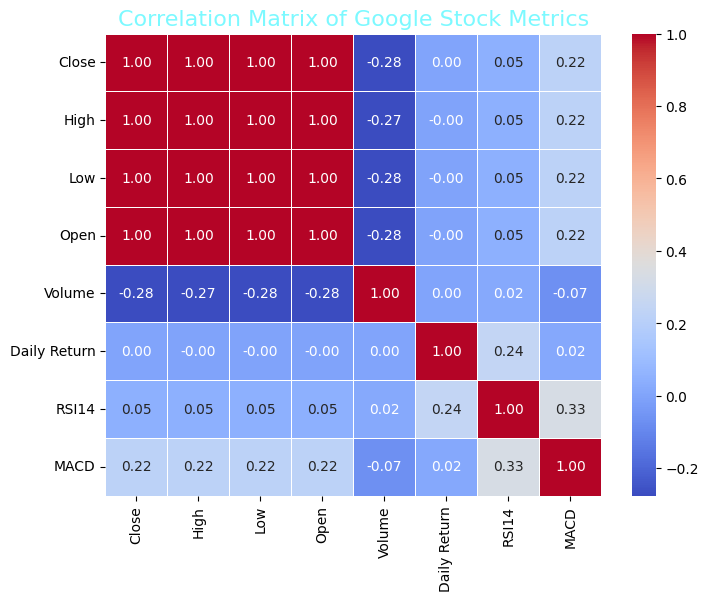

In [15]:
# Heatmap: Correlation Matrix of Key Metrics
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(
    df[["Close", "High", "Low", "Open", "Volume", "Daily Return", "RSI14", "MACD"]].corr(),
    annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5
)
plt.title("Correlation Matrix of Google Stock Metrics", color="#7cf9ff", fontsize=16)
plt.show()


<div style="background-color:#232038; color:#f3f3f3; padding:22px; border-radius:14px; font-size:18px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;">
  <h2 style="color:#7cf9ff; margin-top:0;">🕯️ Step 5D: Candlestick Chart — Price Action Analysis</h2>
  <p>Candlestick charts are a staple for professional traders, showing open, high, low, and close prices for each day. They help spot patterns, reversals, and key support/resistance levels.</p>
</div>


In [16]:
# Candlestick Chart: Price Action Analysis
fig = go.Figure(
    data=[
        go.Candlestick(
            x=df["Date"],
            open=df["Open"],
            high=df["High"],
            low=df["Low"],
            close=df["Close"],
            increasing_line_color="#00e676",
            decreasing_line_color="#ff1744",
            name="Candlestick"
        )
    ]
)
fig.update_layout(
    title="Google Stock Candlestick Chart",
    xaxis_title="Date",
    yaxis_title="Price (USD)",
    template="plotly_dark"
)
fig.show()


<div style="background-color:#232038; color:#f3f3f3; padding:22px; border-radius:14px; font-size:18px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;">
  <h2 style="color:#7cf9ff; margin-top:0;">⚠️ Step 6: Risk Metrics Visualization</h2>
  <p></p>
</div>


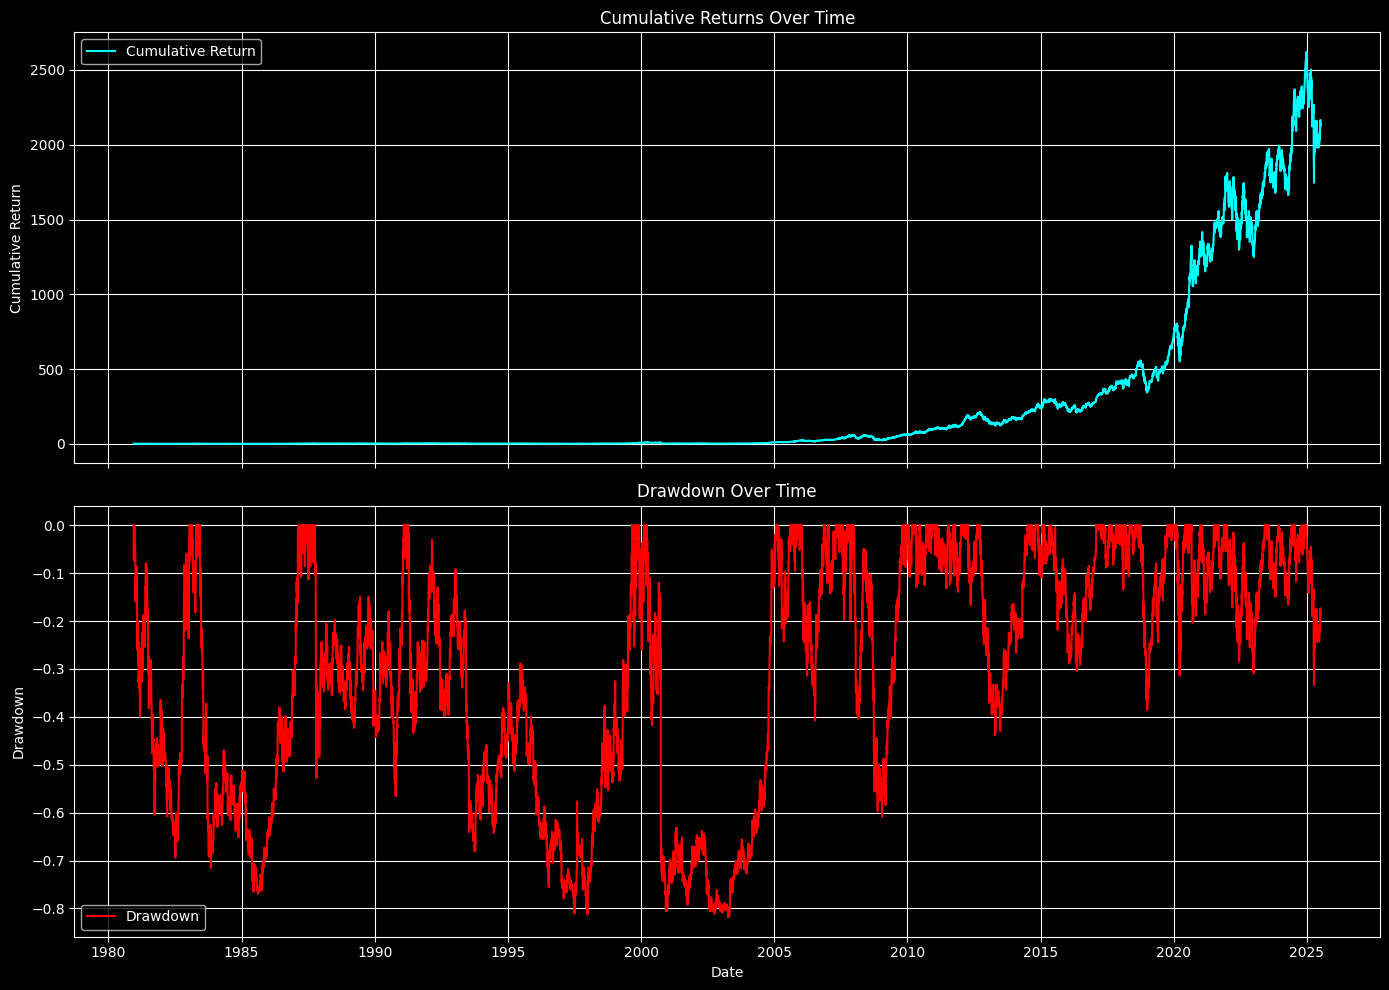

In [17]:
# Step 6: Risk Metrics Visualization

plt.style.use('dark_background')
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

ax[0].plot(df['Date'], df['Cumulative Return'], label='Cumulative Return', color='cyan')
ax[0].set_title('Cumulative Returns Over Time')
ax[0].set_ylabel('Cumulative Return')
ax[0].grid(True)
ax[0].legend()

ax[1].plot(df['Date'], df['Drawdown'], label='Drawdown', color='red')
ax[1].set_title('Drawdown Over Time')
ax[1].set_ylabel('Drawdown')
ax[1].set_xlabel('Date')
ax[1].grid(True)
ax[1].legend()

plt.tight_layout()
plt.show()
